# "Traditional" Text Classification with Scikit-learn

In this notebook, we're going to experiment with a few "traditional" approaches to text classification. These approaches pre-date the deep learning revolution in Natural Language Processing, but are often quick and effective ways of training a text classifier. 

## Data

For our data, we're going to work with the [20 Newsgroups data set](http://qwone.com/~jason/20Newsgroups/), a classic collection of text documents that is often used as a benchmark for text classification models. The set contains texts about various topics, ranging from computer hardward to religion. Some of the topics are closely related to each other (such as "IBM PC hardware" and "Mac hardware"), while others are very different (such as "religion" or "hockey"). The 20 Newsgroups comes shipped with the [Scikit-learn machine learning library](https://scikit-learn.org/stable/), our main tool for this exercise. It has been split into training set of 11,314 texts and a test set of 7,532 texts.

In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532


## Preprocessing

The first step in the development of any NLP model is text preprocessing. This means we're going to transform our texts from word sequences to feature vectors. These feature vectors contain their values for each of a large number of features.

In this experiment, we're going to work with so-called "bag-of-word" approaches. Bag-of-word methods treat every text as an unordered collection of words (or optionally, ngrams), and the raw feature vectors simply tell us how often each word (or ngram) occurs in a text. In Scikit-learn, we can construct these raw feature vectors with the `CountVectorizer`, which tokenizes a text and counts the number of times any given text contains every token in the corpus. 

However, these raw counts are not very informative yet. This is because the raw feature vectors of most texts in the same language will be very similar. For example, most texts in English contain many instances of relatively uninformative words, such as *a*, *the* or *be*. Instead, what we're interested in are words like *computer* or *hardware*: words that occur often in one text, but not very often in the corpus as a whole. Therefore we're going to weight all features by their [tf-idf score](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which counts the number of times every token appears in a text and divides it by (the logarithm of) the percentage of corpus documents that contain that token. This weighting is performed by Scikit-learn's `TfidfTransformer`.

To obtain the weighted feature vectors, we combine the `CountVectorizer` and `TfidfTransformer` in a `Pipeline`, and fit this pipeline on the training data. We then transform both the training texts and the test texts to a collection of such weighted feature vectors. Scikit-learn also has a `TfidfVectorizer`, which achieves the same result as our pipeline.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

preprocessing = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])
  
print("Preprocessing training data...")
train_preprocessed = preprocessing.fit_transform(train_data.data)

print("Preprocessing test data...")
test_preprocessed = preprocessing.transform(test_data.data)

Preprocessing training data...
Preprocessing test data...


## Training

Next, we train a text classifier on the preprocessed training data. We're going to experiment with three classic text classification models: Naive Bayes, Support Vector Machines and Logistic Regression. 

[Naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) are extremely simple classifiers that assume all features are independent of each other. They just learn how frequent all classes are and how frequently each feature occurs in a class. To classify a new text, they simply multiply the probabilities for every feature $x_i$ given each class $C$ and pick the class that gives the highest probability: 

\begin{equation*}
\hat y = argmax_k\  p(C_k) \prod_{i=1}^n p(x_i \mid C_k)
\end{equation*}

Naive Bayes Classifiers are very quick to train, but usually fall behind in terms of performance.

[Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine) are much more advanced than Naive Bayes classifiers. They try to find the hyperplane in the feature space that best separates the data from the different classes. They do so by picking the hyperplane that maximizes the distance to the nearest data point on each side. When the classes are not linearly separable, SVMs map the data into a higher-dimensional space where a linear separation can hopefully be found. SVMs often achieve very good performance in text classification tasks.

[Logistic Regression models](https://en.wikipedia.org/wiki/Logistic_regression), finally, model the log-odds $l$, or $log(p/(1-p))$, of a class as a linear model and estimate the parameters $\beta$ of the model during training: 

\begin{equation*}
l = \beta_0 + \sum_{i=1}^n \beta_i x_i
\end{equation*}

Like SVMs, they often achieve great performance in text classification.

We train our three classifiers in Scikit-learn with the `fit` method, giving it the preprocessed training text and the correct classes for each text as parameters.


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression

nb_classifier = MultinomialNB()
svm_classifier = SGDClassifier(max_iter=1000, tol=1e-3)
lr_classifier = LogisticRegression(solver="lbfgs", multi_class="ovr")

print("Training Naive Bayes classifier...")
nb_classifier.fit(train_preprocessed, train_data.target)

print("Training SVM classifier...")
svm_classifier.fit(train_preprocessed, train_data.target)

print("Training Logistic Regression classifier...")
lr_classifier.fit(train_preprocessed, train_data.target)

Training Naive Bayes classifier...
Training SVM classifier...
Training Logistic Regression classifier...


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Testing

Now it's time to test how well each classifier performs. To this goal, we have each classifier `predict` the label for all texts in our preprocessed test set.

In [5]:
nb_predictions = nb_classifier.predict(test_preprocessed)
svm_predictions = svm_classifier.predict(test_preprocessed)
lr_predictions = lr_classifier.predict(test_preprocessed)

## Evaluation

Let's now evaluate the output. First we compute the simple accuracy: the proportion of test texts that got the correct label. The Naive Bayes classifier assigned the correct label in 77.4% of the cases, the logistic regression model achieves an accuracy of 82.8%, and the Support Vector Machine got the label right 85.2% of the time.

In [6]:
import numpy as np

print("NB Accuracy:", np.mean(nb_predictions == test_data.target))
print("SVM Accuracy:", np.mean(svm_predictions == test_data.target))
print("LR Accuracy:", np.mean(lr_predictions == test_data.target))

NB Accuracy: 0.7738980350504514
SVM Accuracy: 0.8556824216675518
LR Accuracy: 0.8278013807753585


A more detailed classification report for the SVM classifier shows the precision, recall and F-score for the individual classes: 

- Precision is the number of times the classifier predicted a class correctly, divided by the total number of times it predicted this class. 
- Recall is the proportion of documents with a given class that were labelled correctly by the classifier. 
- The F1-score is the harmonic mean between precision and recall: $2*P*R/(P+R)$

The detailed report shows, for example, that the sports classes were quite easy to predict, while the computer and some of the politics classes proved much more difficult. 

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_data.target, svm_predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.77      0.79       319
           comp.graphics       0.78      0.79      0.78       389
 comp.os.ms-windows.misc       0.76      0.74      0.75       394
comp.sys.ibm.pc.hardware       0.73      0.76      0.75       392
   comp.sys.mac.hardware       0.84      0.87      0.85       385
          comp.windows.x       0.87      0.76      0.81       395
            misc.forsale       0.84      0.91      0.87       390
               rec.autos       0.92      0.91      0.92       396
         rec.motorcycles       0.95      0.95      0.95       398
      rec.sport.baseball       0.91      0.95      0.93       397
        rec.sport.hockey       0.96      0.98      0.97       399
               sci.crypt       0.91      0.95      0.93       396
         sci.electronics       0.83      0.79      0.81       393
                 sci.med       0.90      0.89      0.89       396
         

### Confusion matrix

Finally, we're going to visualize our results in even more detail, using a so-called confusion matrix. A confusion matrix helps us better understand the errors our classifier makes. Its rows display the actual labels, its columns show the predictions of our classifier. This means all correct predictions will lie on the diagonal, where the actual label and the predicted label are the same. The predictions elsewhere in the matrix help us understand what classes are often mixed up by our classifier. Our confusion matrix shows, for example, that 91 documents with the label `talk.politics.misc` incorrectly received the label `talk.politics.guns`. Similarly, our classifier sometimes fails to tell apart the two religion classes, and gets quite mixed up in the computer topics in the top left corner.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text xticklabel objects>)

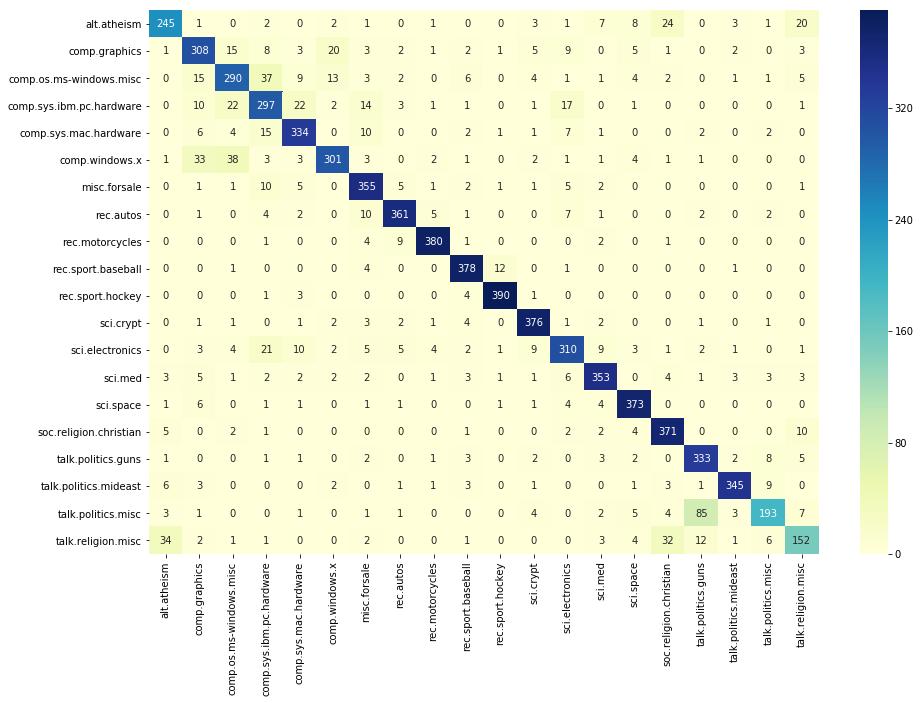

In [8]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data.target, svm_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_data.target_names, columns=test_data.target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)